<a href="https://colab.research.google.com/github/srikumarA/Deep_learning/blob/main/transfer_learning_food101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Oct  7 20:18:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## Creating helper function
# we cant just rewrite them for every notebook, we can import the stuff
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-07 20:18:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-07 20:18:59 (96.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

# lets get the data
### wea re going to use tf.keras.applications instead of hub

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-10-07 20:19:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 64.233.170.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  25.0MB/s    in 7.7s    

2023-10-07 20:19:11 (20.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
unzip_data("10_food_classes_10_percent.zip")

In [ ]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [ ]:
train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf
img_size=(224,224)
batch_size=32
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                          image_size=img_size,
                                                                          label_mode="categorical",
                                                                          batch_size=batch_size)
test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                              image_size=img_size,
                                                              batch_size=batch_size,
                                                              label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
#check out the class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

Lets get into building a neural network using functional API

## Model 0: baseline model

Functional API gives us more flexibility allows us to perform skipping and multi layer fusion

In [ ]:
# 1. Create base model2
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
# .2 .freeze the base model's weights
base_model.trainable=False
# 3. Create input layer for the model
inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")
# 4. Got to normalize the inputs especially for resnet 50v2
#x=tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)
# 5 pass the inputs to the base model
x=base_model(inputs)
print(f"shape after passing through the base model{x.shape}")
#6. average pool the outputs
x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
print(f"shape after passing through the global average pooling 2D{x.shape}")
# 7. create the output activation layer
outputs=tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

# 8. combine the inputs with the outputs into a model
model_0=tf.keras.Model(inputs,outputs)

24274472/24274472 [==============================] - 2s 0us/step
shape after passing through the base model(None, 7, 7, 1280)
shape after passing through the global average pooling 2D(None, 1280)


In [ ]:
model_0.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_0=model_0.fit(train_data_10_percent,epochs=5,steps_per_epoch=len(train_data_10_percent),validation_data=test_data,validation_steps=int(0.25*len(test_data)),callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="10_percent")])

Saving TensorBoard log files to: transfer_learning/10_percent/20231007-201932
Epoch 1/5
24/24 [==============================] - 37s 332ms/step - loss: 1.8799 - accuracy: 0.4440 - val_loss: 1.3424 - val_accuracy: 0.7204
Epoch 2/5
24/24 [==============================] - 6s 207ms/step - loss: 1.1642 - accuracy: 0.7413 - val_loss: 0.9009 - val_accuracy: 0.8207
Epoch 3/5
24/24 [==============================] - 8s 295ms/step - loss: 0.8714 - accuracy: 0.7987 - val_loss: 0.7346 - val_accuracy: 0.8207
Epoch 4/5
24/24 [==============================] - 6s 204ms/step - loss: 0.6968 - accuracy: 0.8547 - val_loss: 0.6295 - val_accuracy: 0.8454
Epoch 5/5
24/24 [==============================] - 7s 293ms/step - loss: 0.5994 - accuracy: 0.8680 - val_loss: 0.5820 - val_accuracy: 0.8470


In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 10s 116ms/step - loss: 0.5738 - accuracy: 0.8516


[0.5737764239311218, 0.8515999913215637]

In [ ]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_2D   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


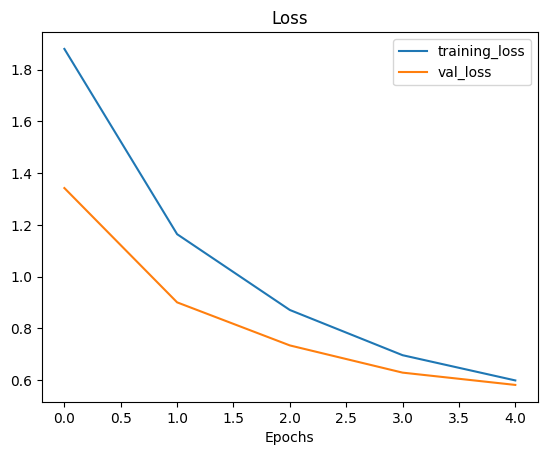

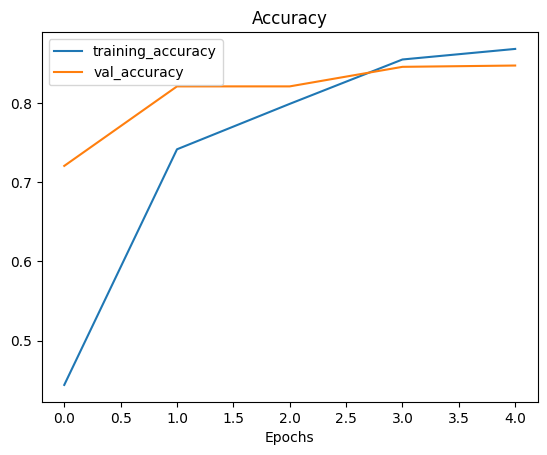

In [ ]:
plot_loss_curves(history_0)

# getting a feature vector

what our global average pooling d does is, it reduces the input tensor size from 4 dims to 1 dims just like Flatten, so whats the difference between them,

Flatten gives you whole tensor by just resizing it whereas average pooling does average pooling which reduces the dimensions and size unlike the flatten.





In [ ]:
# define the input shape
input_shape=(1,4,4,3)

#creating a random tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)
print(f"Random input tensor :\n {input_tensor} \n")

#pass it through the global average pooling layer
glb_avg_pool_tensor=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled input tensor \n {glb_avg_pool_tensor} \n")

Random input tensor :
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 

2D global average pooled input tensor 
 [[-0.09368646 -0.45840448 -0.2885598 ]] 



In [ ]:
input_tensor.shape,glb_avg_pool_tensor.shape

(TensorShape([1, 4, 4, 3]), TensorShape([1, 3]))

In [ ]:
# lets replicate it to understand it better
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

from keras.src.backend import learning_phase
## Running a series of transfer learning experiments

We have seen the results of transfer learning.
1. Model 1: feature extraction transfer learning 1% with augmentation
2. Model 2: Use feature extractor along with data augmentation that is inbuilt in the model
3. Model 3: use fine tuning transfer learning 10% of the data
4. Model 4: fine tuning tl with 100% data

In [ ]:
# download and unzip the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzipd_data=unzip_data("10_food_classes_1_percent.zip")

--2023-10-07 20:20:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.207, 142.251.175.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  21.2MB/s    in 7.1s    

2023-10-07 20:21:04 (17.9 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'

In [ ]:
train_dir_1p="10_food_classes_1_percent/train"
test_dir="10_food_classes_1_percent/test"

img_size=(224,224)
batch_size=32
train_data_1p=tf.keras.preprocessing.image_dataset_from_directory(train_dir_1p,
                                                                  batch_size=batch_size,
                                                                  image_size=img_size,
                                                                  label_mode="categorical")

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              batch_size=batch_size,
                                                              image_size=img_size,
                                                              label_mode="categorical")


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## adding daa augmentation within the model instead of ImageDataGenerator

* `tf.keras.layers.experimaental.preprocessing()`

In [ ]:
import tensorflow as tf

data_augmentation=tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
],name="preprocessing")

(-0.5, 591.5, 564.5, -0.5)

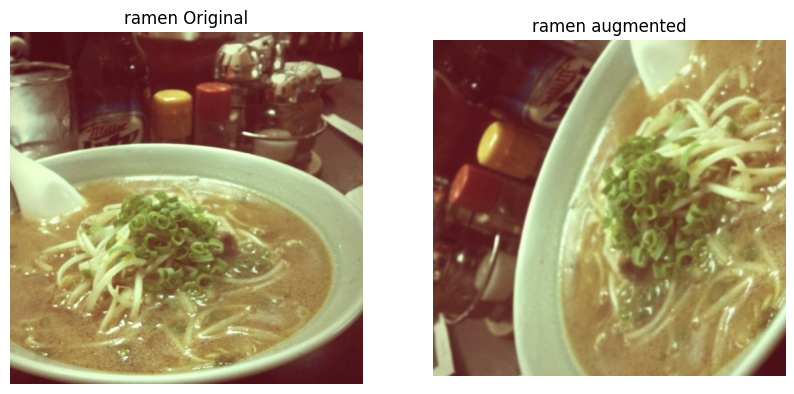

In [ ]:
# lets visualize this
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class=random.choice(train_data_1p.class_names)
target_dir=train_dir+"/"+target_class
random_image=random.choice(os.listdir(target_dir))
img_path=target_dir+"/"+random_image
img=mpimg.imread(img_path)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title(target_class+" Original")
plt.axis(False)
augmented_img=data_augmentation(img)
plt.subplot(1,2,2)
plt.imshow(augmented_img/255.)
plt.title(target_class+" augmented")
plt.axis(False)


## model_1 : feature extraction transfer learning on 1% of the data.

In [ ]:
# setup the input shape and freeze the model
tf.random.set_seed(42)
input_shape=(224,224,3)
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False

#create input layer
inputs=tf.keras.layers.Input(shape=input_shape,name="input_layer")

#add the data augmentation layer
x=data_augmentation(inputs)

# give base model the inputs
x=base_model(x)

#scale down to feature vector
x=tf.keras.layers.GlobalAveragePooling2D(name="glb_avg_pooling")(x)

#put a dense layer
outputs=tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

model_1=tf.keras.Model(inputs,outputs)

#compile the model
model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#train the model
history_1=model_1.fit(train_data_1p,epochs=5,steps_per_epoch=len(train_data_1p),validation_data=test_data,validation_steps=0.25*len(test_data),callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="1_percent_with_da")])

Saving TensorBoard log files to: transfer_learning/1_percent_with_da/20231007-202112
Epoch 1/5
3/3 [==============================] - 29s 5s/step - loss: 2.4827 - accuracy: 0.1286 - val_loss: 2.2622 - val_accuracy: 0.1531
Epoch 2/5
3/3 [==============================] - 7s 3s/step - loss: 2.1500 - accuracy: 0.2143 - val_loss: 2.1712 - val_accuracy: 0.2047
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 2.0593 - accuracy: 0.3000 - val_loss: 2.0628 - val_accuracy: 0.2656
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.9115 - accuracy: 0.4000 - val_loss: 1.9842 - val_accuracy: 0.3406
Epoch 5/5
3/3 [==============================] - 4s 1s/step - loss: 1.7680 - accuracy: 0.5286 - val_loss: 1.9148 - val_accuracy: 0.3969


In [ ]:
results_1p=model_1.evaluate(test_data)
results_1p

79/79 [==============================] - 8s 91ms/step - loss: 1.9447 - accuracy: 0.3436


[1.9446547031402588, 0.34360000491142273]

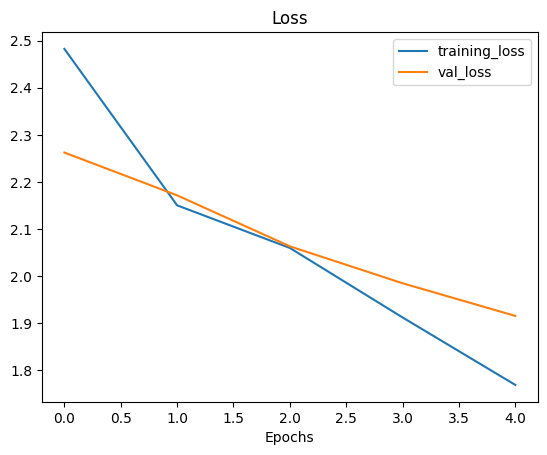

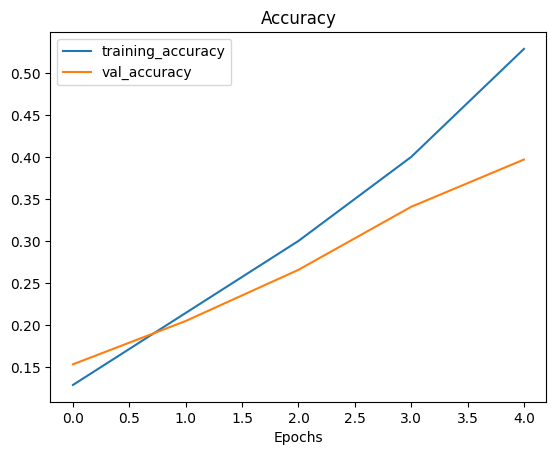

In [ ]:
plot_loss_curves(history_1)

## model 2: feature extraction transfer learning model with 10 percent data and data augmentation


In [ ]:
train_dir_10p="/content/10_food_classes_10_percent/train"
test_dir="/content/10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf
img_size=(224,224)
train_data_10p=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_10p,
                                                                   batch_size=32,
                                                                   image_size=img_size,
                                                                   label_mode="categorical")
test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                              batch_size=32,
                                                              image_size=img_size,
                                                              label_mode="categorical")


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
#creating a new model with data augmentation
from tensorflow.keras import layers,Sequential
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation=Sequential([
    preprocessing.RandomFlip(),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    #preprocessing.Rescaling(1/255.) #efficient model doesnt need recaling as it is inbuilt
],name="data_augmentation_layer")
input_shape=(224,224,3)
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False

#create input
input=layers.Input(shape=input_shape,name="input_layer")
x=data_augmentation(input)
x=base_model(x,training=False) # this is ensure that batchnormalization isnt affected
x=layers.GlobalAveragePooling2D(name="glb_avg_pooling2d")(x)
output=layers.Dense(10,activation="softmax",name="output_layer")(x)

Model_2=tf.keras.Model(input,output)

Model_2.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### creating checkpoints callbacks so
saves the full model or the weigths during training so that incase of timeouts we can cntinue from the same

In [ ]:
checkpoint_path="10p/model_weights/checktpoint.ckpt"

#create a model checkpoint callback
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_weights_only=True,
                                                       save_best_only=False,
                                                       save_freq="epoch",
                                                       verbose=1)

In [ ]:
initial_epoch=5
history_2=Model_2.fit(train_data_10p,epochs=initial_epoch,steps_per_epoch=len(train_data_10p),validation_data=test_data,validation_steps=int(0.25*len(test_data)),
                      callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                            experiment_name="10_percent_data_aug"),checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20231007-204632
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0762 - accuracy: 0.3120
Epoch 1: saving model to 10p/model_weights/checktpoint.ckpt
24/24 [==============================] - 22s 544ms/step - loss: 2.0762 - accuracy: 0.3120 - val_loss: 1.5479 - val_accuracy: 0.6102
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4753 - accuracy: 0.6240
Epoch 2: saving model to 10p/model_weights/checktpoint.ckpt
24/24 [==============================] - 12s 494ms/step - loss: 1.4753 - accuracy: 0.6240 - val_loss: 1.1328 - val_accuracy: 0.7500
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1804 - accuracy: 0.7067
Epoch 3: saving model to 10p/model_weights/checktpoint.ckpt
24/24 [==============================] - 13s 533ms/step - loss: 1.1804 - accuracy: 0.7067 - val_loss: 0.9059 - val_accuracy: 0.7977
Epoch 4/5
24/24 [==============================] - ETA: 0s

In [ ]:
results_2=Model_2.evaluate(test_data)

79/79 [==============================] - 5s 61ms/step - loss: 0.6863 - accuracy: 0.8260


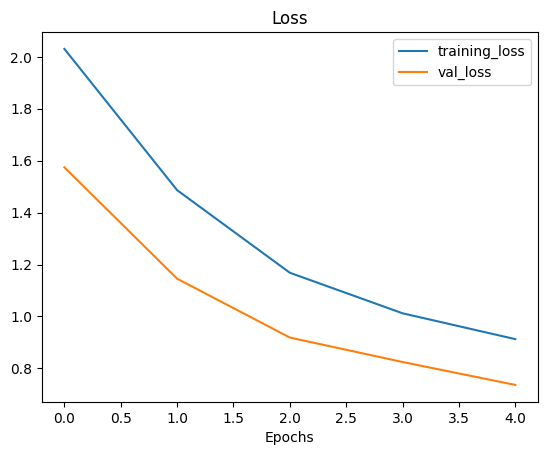

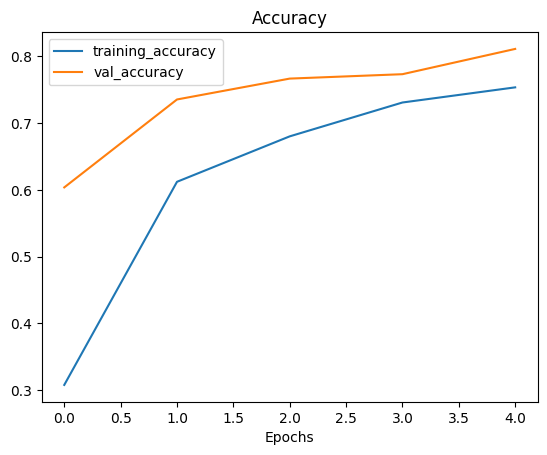

In [ ]:
plot_loss_curves(history_2)

### Loading saved checkpoints and continuing our training


In [ ]:
Model_2.load_weights(checkpoint_path)


## Fine tuning existing model in transfer learning

1st we extract feature then fine tuning is done
in fine tuning few layers near the output layer are unfrozen for training, the number of layers unfrozen is arbitary and depends upon the experiment.

Why dont we mess witht the layers near input layers, because they learn basic patterns or bigger patterns that is general for the domain of the problem whereas the top region(when we flip the model upside) or near to output layers learns more minute patterns.

In [ ]:
Model_2.layers

In [ ]:
for layer in Model_2.layers:
  print(layer.name,layer.trainable)

input_layer True
data_augmentation_layer True
efficientnetv2-b0 False
glb_avg_pooling2d True
output_layer True


In [ ]:
for i,layer in enumerate(Model_2.layers[2].layers):
  print(i,layer.name,layer.trainable)
  if (layer.trainable):
    print(f"-------------Trainable layer--------{layer.name}")

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
#begin fine tuning last 10 layers will be trainable-experiment

base_model.trainable=False
all_layer=Model_2.layers[2].layers[len(base_model.layers)-10:]
for layer in all_layer:
  layer.trainable=True

In [ ]:
for i,layer in enumerate(base_model.layers):
  print(i,layer.name,layer.trainable)
  if (layer.trainable):
    print(f"-------------Trainable layer--------{layer.name}")

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
base_model.trainable=True
for layer in base_model.layers[:-10]:
  layer.trainable=False
Model_2.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=["accuracy"])

In [ ]:
len(Model_2.trainable_variables)

12

In [ ]:
fine_tune_epochs=initial_epoch+5

#refit the model
history_fine_2=Model_2.fit(train_data_10p,
                           epochs=fine_tune_epochs,
                           steps_per_epoch=len(train_data_10p),
                           validation_data=test_data,
                           validation_steps=int(0.25*len(test_data)),
                           initial_epoch=history_2.epoch[-1],
                           callbacks=[create_tensorboard_callback(dir_name='transfer_learning',experiment_name='10p_finetune_l10'),checkpoint_callback]
                           )

Saving TensorBoard log files to: transfer_learning/10p_finetune_l10/20231007-202517
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.7662 - accuracy: 0.7733
Epoch 5: saving model to 10p/model_weights/checktpoint.ckpt
24/24 [==============================] - 27s 642ms/step - loss: 0.7662 - accuracy: 0.7733 - val_loss: 0.5736 - val_accuracy: 0.8109
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.6844 - accuracy: 0.7840
Epoch 6: saving model to 10p/model_weights/checktpoint.ckpt
24/24 [==============================] - 15s 596ms/step - loss: 0.6844 - accuracy: 0.7840 - val_loss: 0.5576 - val_accuracy: 0.8207
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.6301 - accuracy: 0.7920
Epoch 7: saving model to 10p/model_weights/checktpoint.ckpt
24/24 [==============================] - 14s 562ms/step - loss: 0.6301 - accuracy: 0.7920 - val_loss: 0.5499 - val_accuracy: 0.8125
Epoch 8/10
24/24 [==============================] - ETA: 0

In [ ]:
results_3=Model_2.evaluate(test_data)

79/79 [==============================] - 6s 76ms/step - loss: 0.4872 - accuracy: 0.8340


In [ ]:
results_2

[0.7156848907470703, 0.8080000281333923]

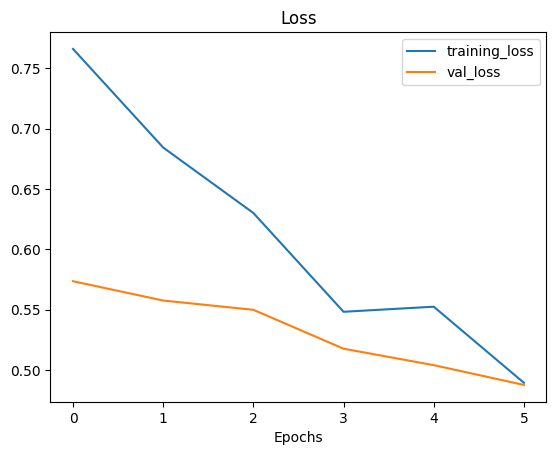

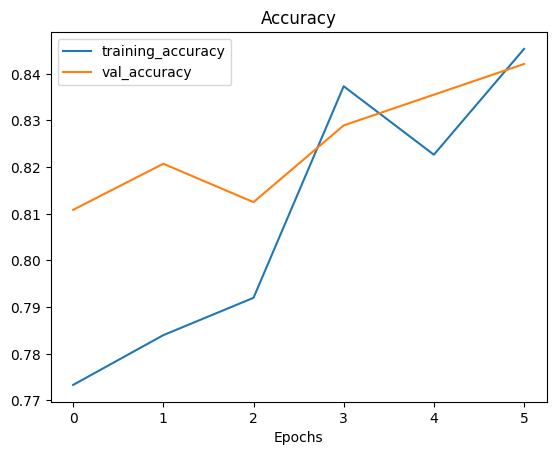

In [ ]:
plot_loss_curves(history_fine_2)

The plot loss curves needs to be upgraded for our use case of fine tuning

In [ ]:
def compare_histories(original_history,new_history,initial_epochs=initial_epoch):
  """
  Compares two tensorflow history objects.
  """
  acc=original_history.history["accuracy"]
  loss=original_history.history['loss']

  val_acc=original_history.history['val_accuracy']
  val_loss=original_history.history['val_loss']

  #combine the initial training curves with the fine tuning
  total_acc=acc+new_history.history['accuracy']
  total_loss=loss+new_history.history['loss']
  total_val_acc=val_acc+new_history.history['val_accuracy']
  total_val_loss=val_loss+new_history.history['val_loss']

  #make plots
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  plt.plot(total_acc,label="training accuracy")
  plt.plot(total_val_acc,label="val_accuracy")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="start Fine tuning")
  plt.legend(loc="lower right")
  plt.title("Training and validation accuracy")

  plt.subplot(1,2,2)
  plt.plot(total_loss,label="training loss")
  plt.plot(total_val_loss,label="validation loss")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="start Fine tuning")
  plt.legend(loc="upper right")
  plt.title("loss curve")


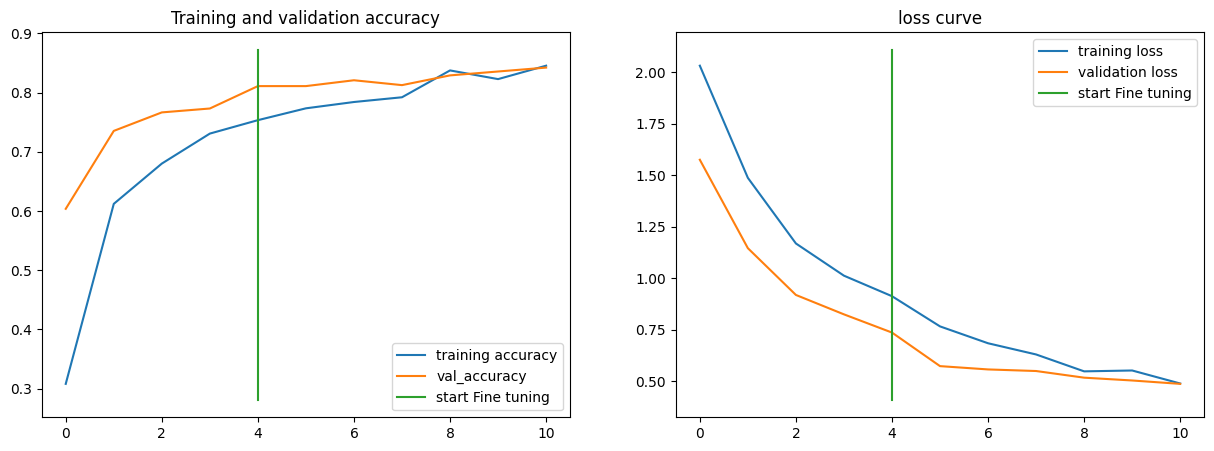

In [ ]:
compare_histories(history_2,history_fine_2,5)

## Model_4: Fine Tuning on all the data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2023-10-07 20:31:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.207, 142.251.10.207, 142.251.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  21.1MB/s    in 24s     

2023-10-07 20:32:02 (20.2 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# get the data
train_dir="/content/10_food_classes_all_data/train"
test_dir="/content/10_food_classes_all_data/test"

In [ ]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 

In [ ]:
batch_size=32
img_size=(224,224)
train_data_all=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                   batch_size=batch_size,
                                                                   image_size=img_size,
                                                                   label_mode="categorical")
test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                              batch_size=batch_size,
                                                              image_size=img_size,
                                                              label_mode="categorical")

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


To train a fine tuning model we have to revert model 2 to its feature extraction weights

In [ ]:
Model_2.evaluate(test_data)

79/79 [==============================] - 7s 80ms/step - loss: 0.4872 - accuracy: 0.8340


[0.48717835545539856, 0.8339999914169312]

In [ ]:
Model_2.load_weights(checkpoint_path)

In [ ]:
Model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.6863 - accuracy: 0.8260


[0.6863105893135071, 0.8259999752044678]

In [ ]:
results_2

[0.6863105893135071, 0.8259999752044678]

In [ ]:
for layer_number,layer in enumerate(Model_2.layers):
  print(layer_number,layer.name,layer.trainable)

0 input_layer True
1 data_augmentation_layer True
2 efficientnetv2-b0 False
3 glb_avg_pooling2d True
4 output_layer True


In [ ]:
for layer_number, layer in enumerate(Model_2.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
# its time to do it
Model_2.layers[2].trainable=True

for layer in Model_2.layers[2].layers[:len(Model_2.layers[2].layers)-10]:
  layer.trainable=False

In [ ]:
Model_2.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=["accuracy"])


In [ ]:
initial_epochs=5
fine_tune_epochs=initial_epochs+5

history_4=Model_2.fit(train_data_all,epochs=fine_tune_epochs,steps_per_epoch=len(train_data_all),validation_data=test_data,validation_steps=int(0.25*len(test_data)),initial_epoch=initial_epochs,callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="fine_tune_100p_data")])

Saving TensorBoard log files to: transfer_learning/fine_tune_100p_data/20231007-210303
Epoch 6/10
235/235 [==============================] - 93s 352ms/step - loss: 0.7816 - accuracy: 0.7489 - val_loss: 0.3911 - val_accuracy: 0.8750
Epoch 7/10
235/235 [==============================] - 69s 293ms/step - loss: 0.6589 - accuracy: 0.7861 - val_loss: 0.3301 - val_accuracy: 0.9030
Epoch 8/10
235/235 [==============================] - 60s 251ms/step - loss: 0.6076 - accuracy: 0.8037 - val_loss: 0.2985 - val_accuracy: 0.9194
Epoch 9/10
235/235 [==============================] - 56s 237ms/step - loss: 0.5630 - accuracy: 0.8179 - val_loss: 0.3188 - val_accuracy: 0.9046
Epoch 10/10
235/235 [==============================] - 51s 216ms/step - loss: 0.5372 - accuracy: 0.8267 - val_loss: 0.2680 - val_accuracy: 0.9260


In [ ]:
results_4=Model_2.evaluate(test_data)

79/79 [==============================] - 6s 64ms/step - loss: 0.2900 - accuracy: 0.9032


In [ ]:
results_4

[0.2899831235408783, 0.9031999707221985]

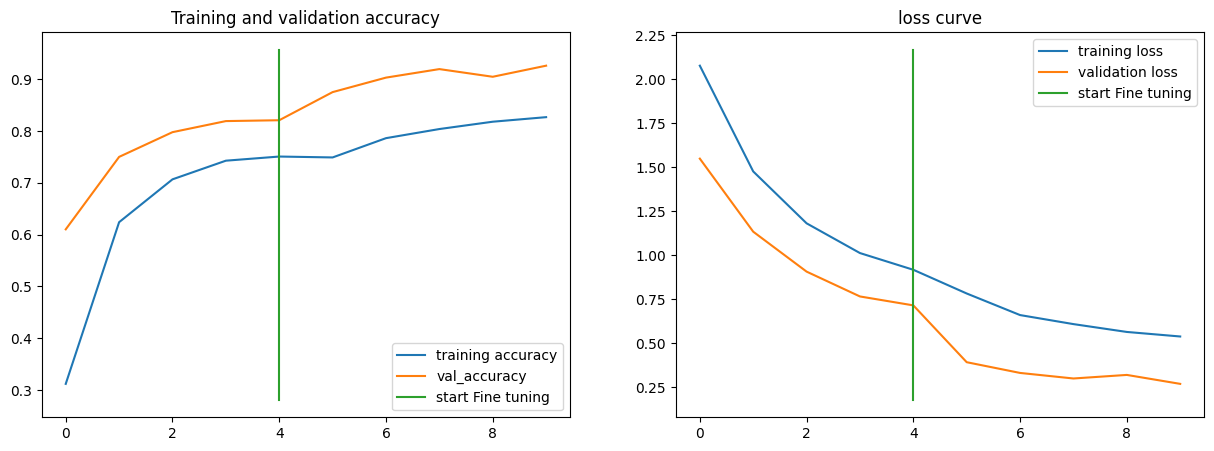

In [ ]:
compare_histories(history_2,history_4,5)

In [ ]:
## viewing our experiment data on tensorboard
# view tensorboard logs
!tensorboard dev upload --logdir ./transfer_learning \
--name " Transfer learning experiments on 101 food classes" \
--description "A series of experiments with finetuning" \
--one_shot

2023-10-07 21:20:22.053412: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.10/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.10/dist-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/program.py", line 276, in main
    return runner(self.flags) or 0
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/uploader/uploader_subcommand.py", line 691, in run
    return _run(flags, self._experiment_url_callback)
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/uploader/uploader_subcommand.py", li